# Much of the early lines of code are 
# for putting the correct sample into a 
# dataframe

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from matplotlib import colors as mcolors
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
import astropy.units as u
import statistics as stats
from astropy import constants as const
import os

In [2]:
os.getcwd()

'/Volumes/quinn_casey/eboss/total_bins/code_plots'

In [3]:
hdu = fits.open('/Volumes/quinn_casey/eboss/spLine_trim_dr16_eboss.fits')
hdu1 = fits.open('/Volumes/quinn_casey/eboss/spAll_trim_dr16_eboss.fits')

In [4]:
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
o3 = hdu[1].data['OIII_5007_FLUX'].tolist()
o3_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()
n2 = hdu[1].data['NII_6584_FLUX'].tolist()
n2_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()

v_disp = hdu1[1].data['VDISP'].tolist()
v_disp_err = hdu1[1].data['VDISP_ERR'].tolist()
o3_sigma = hdu[1].data['OIII_5007_SIGMA'].tolist()
o3_sigma_err = hdu[1].data['OIII_5007_SIGMA_ERR'].tolist()

z = hdu[1].data['Z'].tolist()
plate = hdu[1].data['PLATE'].tolist()
mjd = hdu[1].data['MJD'].tolist()
fiber = hdu[1].data['FIBER'].tolist()
ra = hdu[1].data['RA'].tolist()
dec = hdu[1].data['DEC'].tolist()

In [5]:
data_names = ['ha', 'ha_err', 'hb', 'hb_err', 'o3', 'o3_err', 'n2', 'n2_err',
              'v_disp', 'v_disp_err', 'o3_sigma', 'o3_sigma_err',
              'z', 'plate', 'mjd', 'fiber', 'ra', 'dec']
data_dict = {'ha':ha, 'ha_err':ha_err, 'hb':hb, 'hb_err':hb_err, 'o3':o3, 
            'o3_err':o3_err, 'n2':n2, 'n2_err':n2_err, 
             'v_disp':v_disp, 'v_disp_err':v_disp_err, 'o3_sigma':o3_sigma, 'o3_sigma_err':o3_sigma_err,
             'z':z, 'plate':plate, 'mjd':mjd, 'fiber':fiber, 'ra':ra, 'dec':dec}
df = pd.DataFrame(data_dict)

for name in data_names: 
    df = df.loc[df[name].notnull()]

In [6]:
df = df.loc[(df['ha']/df['ha_err']) > 3]
df = df.loc[(df['hb']/df['hb_err']) > 3]
df = df.loc[(df['n2']/df['n2_err']) > 3]
df = df.loc[(df['o3']/df['o3_err']) > 3]

In [7]:
# correcting for instrumental error (60)

df = df.loc[(df['o3_sigma']/df['o3_sigma_err']) > 3]
df['o3_sigma_new'] = np.sqrt( ((df['o3_sigma'])**2) - (60**2) )

df = df.drop((['o3_sigma', 'o3_sigma_err']), axis=1)
df = df.rename(columns={'o3_sigma_new':'o3_sigma'})

/Users/quinncasey/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
df = df.query('z > 0.005 & z <= 0.55')

df['lookback_time_Gyr'] = cosmo.age(df['z'])

df1 = df.query('lookback_time_Gyr < 13.397394067278762 & lookback_time_Gyr >= 12.068407817585271')
df2 = df.query('lookback_time_Gyr < 12.068407817585271 & lookback_time_Gyr >= 10.739421567891778')
df3 = df.query('lookback_time_Gyr < 10.739421567891778 & lookback_time_Gyr >= 9.410435318198287')
df4 = df.query('lookback_time_Gyr < 9.410435318198287 & lookback_time_Gyr >= 8.081449068504796')

In [9]:
# this big chunk of code correctly splits galaxies into AGNs, SFs, & LM-AGNs
# (it's not pretty but it works!)

def low_met_agn_1(df1): 
    x_values = df1.x.values
    y_values = df1.y.values.tolist()
    
    ha_1 = df1['ha'].values
    hb_1 = df1['hb'].values
    n2_1 = df1['n2'].values
    o3_1 = df1['o3'].values
    v_disp_1 = df1['v_disp'].values
    o3_sigma_1 = df1['o3_sigma'].values
    z_1 = df1['z'].values
    plate_1 = df1['plate'].values
    mjd_1 = df1['mjd'].values
    fiber_1 = df1['fiber'].values
    ra_1 = df1['ra'].values
    dec_1 = df1['dec'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df1.loc[:,"z"].median())))+1.4+0.03*(df1.loc[:,"z"].median())
    
    df1 = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df1.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df1.append('agn')
        elif x > 0.0:
            df1.append('agn')
        else: 
            df1.append('starform')
            
    return df1, ha_1, hb_1, n2_1, o3_1, v_disp_1, o3_sigma_1, z_1, plate_1, mjd_1, fiber_1, ra_1, dec_1

def low_met_agn_2(df2): 
    x_values = df2.x.values
    y_values = df2.y.values.tolist()
    
    ha_2 = df2['ha'].values
    hb_2 = df2['hb'].values
    n2_2 = df2['n2'].values
    o3_2 = df2['o3'].values
    v_disp_2 = df2['v_disp'].values
    o3_sigma_2 = df2['o3_sigma'].values
    z_2 = df2['z'].values
    plate_2 = df2['plate'].values
    mjd_2 = df2['mjd'].values
    fiber_2 = df2['fiber'].values
    ra_2 = df2['ra'].values
    dec_2 = df2['dec'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df2.loc[:,"z"].median())))+1.4+0.03*(df2.loc[:,"z"].median())
    
    df2 = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df2.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df2.append('agn')
        elif x > 0.0:
            df2.append('agn')
        else: 
            df2.append('starform')
            
    return df2, ha_2, hb_2, n2_2, o3_2, v_disp_2, o3_sigma_2, z_2, plate_2, mjd_2, fiber_2, ra_2, dec_2

def low_met_agn_3(df3): 
    x_values = df3.x.values
    y_values = df3.y.values.tolist()
    
    ha_3 = df3['ha'].values
    hb_3 = df3['hb'].values
    n2_3 = df3['n2'].values
    o3_3 = df3['o3'].values
    v_disp_3 = df3['v_disp'].values
    o3_sigma_3 = df3['o3_sigma'].values
    z_3 = df3['z'].values
    plate_3 = df3['plate'].values
    mjd_3 = df3['mjd'].values
    fiber_3 = df3['fiber'].values
    ra_3 = df3['ra'].values
    dec_3 = df3['dec'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df3.loc[:,"z"].median())))+1.4+0.03*(df3.loc[:,"z"].median())
    
    df3 = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df3.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df3.append('agn')
        elif x > 0.0:
            df3.append('agn')
        else: 
            df3.append('starform')
            
    return df3, ha_3, hb_3, n2_3, o3_3, v_disp_3, o3_sigma_3, z_3, plate_3, mjd_3, fiber_3, ra_3, dec_3

def low_met_agn_4(df4): 
    x_values = df4.x.values
    y_values = df4.y.values.tolist()
    
    ha_4 = df4['ha'].values
    hb_4 = df4['hb'].values
    n2_4 = df4['n2'].values
    o3_4 = df4['o3'].values
    v_disp_4 = df4['v_disp'].values
    o3_sigma_4 = df4['o3_sigma'].values
    z_4 = df4['z'].values
    plate_4 = df4['plate'].values
    mjd_4 = df4['mjd'].values
    fiber_4 = df4['fiber'].values
    ra_4 = df4['ra'].values
    dec_4 = df4['dec'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df4.loc[:,"z"].median())))+1.4+0.03*(df4.loc[:,"z"].median())
    
    df4 = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df4.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df4.append('agn')
        elif x > 0.0:
            df4.append('agn')
        else: 
            df4.append('starform')
            
    return df4, ha_4, hb_4, n2_4, o3_4, v_disp_4, o3_sigma_4, z_4, plate_4, mjd_4, fiber_4, ra_4, dec_4

In [10]:
# Recreating dataframe into 4 redshift bins

df1['x'] = np.log10(df1['n2']/df1['ha'])
df1['y'] = np.log10(df1['o3']/df1['hb'])
df11 = low_met_agn_1(df1)
df11 = pd.DataFrame(df11)
df11 = df11.transpose()
df11.columns = ['Type', 'ha', 'hb', 'n2', 'o3', 'v_disp', 'o3_sigma', 'z', 'plate', 'mjd', 'fiber', 'ra', 'dec']


df2['x'] = np.log10(df2['n2']/df2['ha'])
df2['y'] = np.log10(df2['o3']/df2['hb'])
df22 = low_met_agn_2(df2)
df22 = pd.DataFrame(df22)
df22 = df22.transpose()
df22.columns = ['Type', 'ha', 'hb', 'n2', 'o3', 'v_disp', 'o3_sigma', 'z', 'plate', 'mjd', 'fiber', 'ra', 'dec']

df3['x'] = np.log10(df3['n2']/df3['ha'])
df3['y'] = np.log10(df3['o3']/df3['hb'])
df33 = low_met_agn_3(df3)
df33 = pd.DataFrame(df33)
df33 = df33.transpose()
df33.columns = ['Type', 'ha', 'hb', 'n2', 'o3', 'v_disp', 'o3_sigma', 'z', 'plate', 'mjd', 'fiber', 'ra', 'dec']

df4['x'] = np.log10(df4['n2']/df4['ha'])
df4['y'] = np.log10(df4['o3']/df4['hb'])
df44 = low_met_agn_4(df4)
df44 = pd.DataFrame(df44)
df44 = df44.transpose()
df44.columns = ['Type', 'ha', 'hb', 'n2', 'o3', 'v_disp', 'o3_sigma', 'z', 'plate', 'mjd', 'fiber', 'ra', 'dec']

/Users/quinncasey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/quinncasey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/quinncasey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a 

In [11]:
df_lmagn_1 = df11[df11.Type != 'starform']
df_lmagn_1 = df_lmagn_1[df_lmagn_1.Type != 'agn']

df_lmagn_2 = df22[df22.Type != 'starform']
df_lmagn_2 = df_lmagn_2[df_lmagn_2.Type != 'agn']

df_lmagn_3 = df33[df33.Type != 'starform']
df_lmagn_3 = df_lmagn_3[df_lmagn_3.Type != 'agn']

df_lmagn_4 = df44[df44.Type != 'starform']
df_lmagn_4 = df_lmagn_4[df_lmagn_4.Type != 'agn']


df_sf_1 = df11[df11.Type != 'lowmetagn']
df_sf_1 = df_sf_1[df_sf_1.Type != 'agn']

df_sf_2 = df22[df22.Type != 'lowmetagn']
df_sf_2 = df_sf_2[df_sf_2.Type != 'agn']

df_sf_3 = df33[df33.Type != 'lowmetagn']
df_sf_3 = df_sf_3[df_sf_3.Type != 'agn']

df_sf_4 = df44[df44.Type != 'lowmetagn']
df_sf_4 = df_sf_4[df_sf_4.Type != 'agn']



df_agn_1 = df11[df11.Type != 'starform']
df_agn_1 = df_agn_1[df_agn_1.Type != 'lowmetagn']

df_agn_2 = df22[df22.Type != 'starform']
df_agn_2 = df_agn_2[df_agn_2.Type != 'lowmetagn']

df_agn_3 = df33[df33.Type != 'starform']
df_agn_3 = df_agn_3[df_agn_3.Type != 'lowmetagn']

df_agn_4 = df44[df44.Type != 'starform']
df_agn_4 = df_agn_4[df_agn_4.Type != 'lowmetagn']

In [12]:
lmagn_frames = [df_lmagn_1, df_lmagn_2, df_lmagn_3, df_lmagn_4]
dflmagn = pd.concat(lmagn_frames)

sf_frames = [df_sf_1, df_sf_2, df_sf_3, df_sf_4]
dfsf = pd.concat(sf_frames)

agn_frames = [df_agn_1, df_agn_2, df_agn_3, df_agn_4]
dfagn = pd.concat(agn_frames)

In [13]:
print(len(dflmagn))
print(len(dfsf))
print(len(dfagn))

44
44744
29634


# These are the 4 main equations I am using

In [14]:
def lumin(oxy3, d_centimeter):
    # Use rest-frame or not ???
    L = (oxy3)*(4)*(np.pi)*(d_centimeter**2)*(10**-17)
    return L

def bolo_lumin(L_o3):
    # Pennell and Runnoe Eq. 3
    L_bolo_exp = ((0.5617)*(np.log10(L_o3)))+(22.186)
    return L_bolo_exp

# Kormandy and Ho 2018 eq. 7 (pp. 56)
# 0.310 is constant, 200 is in units of km s^-1
# this equation rewrites equation 3 in more physically transparent forms
# NOTE: non-log, but still M_bh is over 10^9M_sun
def kor_ho_7(sigma_o3):
    Mbh_7 = (0.310) * ((sigma_o3/(200))**4.38)
    return Mbh_7 


# equation for eddington luminosity 
def eddington_eq(m_bh, sun):
    L_edd = (1.26*(10**46))*(m_bh/((10**8)*(sun)))
    return L_edd

In [15]:
# convert z into luminosity distance (MPC)
dflmagn['d_mpc'] = cosmo.luminosity_distance(dflmagn['z'].astype(float))
dfsf['d_mpc'] = cosmo.luminosity_distance(dfsf['z'].astype(float))
dfagn['d_mpc'] = cosmo.luminosity_distance(dfagn['z'].astype(float))

#convert d_mpc into d_cm
dflmagn['d_cm'] = dflmagn['d_mpc']*3.08567758128E+24
dfsf['d_cm'] = dfsf['d_mpc']*3.08567758128E+24
dfagn['d_cm'] = dfagn['d_mpc']*3.08567758128E+24

# calculate O3 luminosity
dflmagn['L_o3'] = lumin(dflmagn['o3'], dflmagn['d_cm'])
dfsf['L_o3'] = lumin(dfsf['o3'], dfsf['d_cm'])
dfagn['L_o3'] = lumin(dfagn['o3'], dfagn['d_cm'])

# turn L_o3 into L_bol

dflmagn['log_L_bol'] = bolo_lumin(dflmagn['L_o3'].astype(float))
dfsf['log_L_bol'] = bolo_lumin(dfsf['L_o3'].astype(float))
dfagn['log_L_bol'] = bolo_lumin(dfagn['L_o3'].astype(float))

dflmagn['L_bol'] = 10**(dflmagn['log_L_bol'])
dfagn['L_bol'] = 10**(dfagn['log_L_bol'])
dfsf['L_bol'] = 10**(dfsf['log_L_bol'])

In [16]:
# End of bolometric luminosity calculation
# Now to start the M_bh and L_edd calculation

In [17]:
# running the Kormandy and Ho eq 7  function, using o3_sigma rather than v_disp
# getting M_bh by itself my multiplying by 10^9M_sun

Mbh_10e9Msun_lmagn = kor_ho_7(dflmagn['o3_sigma'])
dflmagn['M_bh'] = (Mbh_10e9Msun_lmagn)*(10**9)*(const.M_sun)

Mbh_10e9Msun_sf = kor_ho_7(dfsf['o3_sigma'])
dfsf['M_bh'] = (Mbh_10e9Msun_sf)*(10**9)*(const.M_sun)

Mbh_10e9Msun_agn = kor_ho_7(dfagn['o3_sigma'])
dfagn['M_bh'] = (Mbh_10e9Msun_agn)*(10**9)*(const.M_sun)

# Calculating L_edd from M_bh

dflmagn['L_edd'] = eddington_eq(dflmagn['M_bh'], const.M_sun)
dfsf['L_edd'] = eddington_eq(dfsf['M_bh'], const.M_sun)
dfagn['L_edd'] = eddington_eq(dfagn['M_bh'], const.M_sun)

dflmagn['ratio'] = np.log10( (dflmagn['L_bol'].astype(float)) / (dflmagn['L_edd'].astype(float)))
dfagn['ratio'] = np.log10( (dfagn['L_bol'].astype(float)) / (dfagn['L_edd'].astype(float)))

In [18]:
# marking galaxies by their eddington ratio (greater or less than 0.8)

dfagn['great_less'] = np.where(dfagn['ratio'] > 0.8, 'greater', np.where(dfagn['ratio'] <= 0.8, 'less', 'equal'))
dflmagn['great_less'] = np.where(dflmagn['ratio'] > 0.8, 'greater', np.where(dflmagn['ratio'] <= 0.8, 'less', 'equal'))

In [19]:
dflmagn_great = dflmagn[dflmagn.great_less != 'less']
dflmagn_less = dflmagn[dflmagn.great_less != 'greater']

dfagn_great = dfagn[dfagn.great_less != 'less']
dfagn_less = dfagn[dfagn.great_less != 'greater']

In [20]:
def agn_classification_line_mod1():
    x = np.linspace(-2, 0, 500)
    y = (0.61/(x-0.02-0.1833*(df.loc[:,"z"].median())))+1.4+0.03*(df.loc[:,"z"].median())
    return x, y


def z_zero_kewl_line():
    x = np.linspace(-2, 0, 500)
    y = 0.61/(x-0.02)+1.2
    return x, y

In [21]:
# Generate random numbers to plot "green line"
# will overplot rand_sig vs L_edd_rand

rand_sig = (np.random.rand(200, 1))*350

M_by_10e9Msun_rand = kor_ho_7(rand_sig)
denom = (const.M_sun)*(10**9)
mass_bh_rand = (M_by_10e9Msun_rand)*(denom)

L_edd_rand_1 = eddington_eq(mass_bh_rand, const.M_sun)
L_edd_rand = np.log10(L_edd_rand_1)

In [22]:
def rand_ratio_line():
    o3sig_rand = np.linspace(1, 500, 500)
    #Lbol_rand = np.linspace(, 48, 500)
    M_by_10e9Msun_rand = kor_ho_7(o3sig_rand)
    
    denom_rand = (1.989*(10**30))*(10**9)
    mass_bh_rand = (M_by_10e9Msun_rand)*(denom_rand)

    L_edd_rand = eddington_eq(mass_bh_rand, 1.989*(10**30))
    log_L_edd_rand = np.log10(L_edd_rand)
    
    return o3sig_rand, log_L_edd_rand

In [23]:
"""
def edd_divider(dflmagn):
    
    o3_sig = dflmagn['o3_sigma'].values.tolist()
    log_iso = dflmagn['log_iso_o3_lumin'].values.tolist()
    
    rand_line = rand_ratio_line()
    
    dflmagn = []
    
    for x, y, line in zip(o3_sig, log_iso, rand_line):
        if x < line and y > line:
            dflmagn.append('less_edd')
        if x > line and y > line:
            dflmagn.append('greater_edd')
        else: 
            dflmagn.append('idk')
    return dflmagn, o3_sig, log_iso
"""

"\ndef edd_divider(dflmagn):\n    \n    o3_sig = dflmagn['o3_sigma'].values.tolist()\n    log_iso = dflmagn['log_iso_o3_lumin'].values.tolist()\n    \n    rand_line = rand_ratio_line()\n    \n    dflmagn = []\n    \n    for x, y, line in zip(o3_sig, log_iso, rand_line):\n        if x < line and y > line:\n            dflmagn.append('less_edd')\n        if x > line and y > line:\n            dflmagn.append('greater_edd')\n        else: \n            dflmagn.append('idk')\n    return dflmagn, o3_sig, log_iso\n"

In [24]:
# I removed 1 AGN galaxy which was an outlier and causing the plot to be squished

print(np.max(dfagn_great['o3_sigma']))
dfagn_less = dfagn_less[dfagn_less['o3_sigma'] < 700]

dfagn = dfagn[dfagn['o3_sigma'] < 700]

105.29018796318188


In [25]:
def plt_density(o3_sig_lmagn_great, o3_sig_lmagn_less, o3_sig_agn_great, o3_sig_agn_less, o3_lumin_lmagn_great, o3_lumin_lmagn_less, o3_lumin_agn_great, o3_lumin_agn_less, rand_sig, L_edd_rand, fig=None, **kwargs):
    
    o3_sig_lmagn_great = np.array(o3_sig_lmagn_great, dtype=float)
    o3_sig_lmagn_less = np.array(o3_sig_lmagn_less, dtype=float)
    o3_sig_agn_great = np.array(o3_sig_agn_great, dtype=float)
    o3_sig_agn_less = np.array(o3_sig_agn_less, dtype=float)
    o3_lumin_lmagn_great = np.array(o3_lumin_lmagn_great, dtype=float)
    o3_lumin_lmagn_less = np.array(o3_lumin_lmagn_less, dtype=float)
    o3_lumin_agn_great = np.array(o3_lumin_agn_great, dtype=float)
    o3_lumin_agn_less = np.array(o3_lumin_agn_less, dtype=float)
    #rand_sig = np.array(rand_sig, dtype=float)
    #L_edd_rand = np.array(L_edd_rand, dtype=float)
    
    #plt.style.use('grayscale')
    fig = plt.figure(figsize=(8,5))
    
    agn_less = plt.hexbin(o3_sig_agn_less, o3_lumin_agn_less, gridsize = 100,  cmap = "copper", mincnt = 1)
    agn_great = plt.scatter(o3_sig_agn_great, o3_lumin_agn_great, c='c', s=10, **kwargs)
    lmagn_less = plt.scatter(o3_sig_lmagn_less, o3_lumin_lmagn_less, c='g', s=30, **kwargs)
    lmagn_great = plt.scatter(o3_sig_lmagn_great, o3_lumin_lmagn_great, c='r', s=30, **kwargs)
    #rand = plt.scatter(rand_sig, L_edd_rand, c='g')
    #rand_line = rand_ratio_line()
    #plt.plot(rand_line[0], rand_line[1], c='g', linewidth=1)

    plt.text(200, 42.8, 'LM-AGNs ($L_{bol}$/$L_{Edd}$ $\leq$ 0.8) N=37, Green', fontsize=10)
    plt.text(200, 42.6, 'LM-AGNs ($L_{bol}$/$L_{Edd}$ > 0.8) N=7, Red', fontsize=10)
    plt.text(200, 42.4, 'AGNs ($L_{bol}$/$L_{Edd}$ > 0.8) N=203, Blue', fontsize=10)
    plt.text(200, 42.2, 'AGNs ($L_{bol}$/$L_{Edd}$ $\leq$ 0.8) N=29437', fontsize=10)
    
    plt.xlim(0, 500)
    plt.ylim(42.1, 47)
    
    plt.title('Velocity Dispersion vs. Bolometric Luminosity for [OIII], (0.005 < z $\leq$ 0.55)')
    plt.xlabel('($\sigma_{[OIII]}$) (km/s)', fontsize=20)
    plt.ylabel('$log_{10}(L_{Bol})$', fontsize=20)
   # plt.savefig('sigma_o3_vs_L_bol_08_ratio.png')
    plt.show()

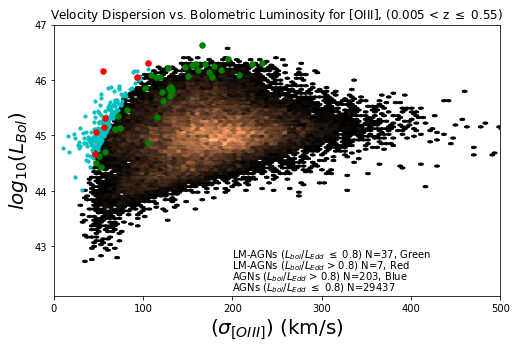

In [26]:
o3_sig_lmagn_great = dflmagn_great['o3_sigma'].values
o3_sig_lmagn_less = dflmagn_less['o3_sigma'].values
o3_sig_agn_great = dfagn_great['o3_sigma'].values
o3_sig_agn_less = dfagn_less['o3_sigma'].values
o3_lumin_lmagn_great = (np.log10(dflmagn_great['L_bol'].astype(float))).values
o3_lumin_lmagn_less = (np.log10(dflmagn_less['L_bol'].astype(float))).values
o3_lumin_agn_great = (np.log10(dfagn_great['L_bol'].astype(float))).values
o3_lumin_agn_less = (np.log10(dfagn_less['L_bol'].astype(float))).values
rand_sig = rand_sig
L_edd_rand = L_edd_rand

plt_density(o3_sig_lmagn_great, o3_sig_lmagn_less, o3_sig_agn_great, o3_sig_agn_less, o3_lumin_lmagn_great, o3_lumin_lmagn_less, o3_lumin_agn_great, o3_lumin_agn_less, rand_sig, L_edd_rand, alpha=1)

In [27]:
def plt_density_2(o3_sig_lmagn_great, o3_sig_lmagn_less, o3_sig_agn, o3_lumin_lmagn_great, o3_lumin_lmagn_less, o3_lumin_agn, rand_sig, L_edd_rand, fig=None, **kwargs):
    
    o3_sig_lmagn_great = np.array(o3_sig_lmagn_great, dtype=float)
    o3_sig_lmagn_less = np.array(o3_sig_lmagn_less, dtype=float)
    o3_sig_agn = np.array(o3_sig_agn, dtype=float)
    #o3_sig_agn_less = np.array(o3_sig_agn_less, dtype=float)
    o3_lumin_lmagn_great = np.array(o3_lumin_lmagn_great, dtype=float)
    o3_lumin_lmagn_less = np.array(o3_lumin_lmagn_less, dtype=float)
    o3_lumin_agn_ = np.array(o3_lumin_agn, dtype=float)
    #o3_lumin_agn_less = np.array(o3_lumin_agn_less, dtype=float)
    rand_sig = np.array(rand_sig, dtype=float)
    L_edd_rand = np.array(L_edd_rand, dtype=float)
    
    #plt.style.use('grayscale')
    fig = plt.figure(figsize=(8,5))
    
    agn = plt.hexbin(o3_sig_agn, o3_lumin_agn, gridsize = 100,  cmap = "copper", mincnt = 1)
    #agn_great = plt.scatter(o3_sig_agn_great, o3_lumin_agn_great, c='m', s=10, **kwargs)
    lmagn_less = plt.scatter(o3_sig_lmagn_less, o3_lumin_lmagn_less, c='g', s=30, **kwargs)
    lmagn_great = plt.scatter(o3_sig_lmagn_great, o3_lumin_lmagn_great, c='r', s=30, **kwargs)
    #rand = plt.scatter(rand_sig, L_edd_rand, c='g', s=5)
    rand_line = rand_ratio_line()
    plt.plot(rand_line[0], rand_line[1], c='g', linewidth=1)

    plt.text(200, 42.8, 'LM-AGNs ($L_{bol}$/$L_{Edd}$ $\leq$ 0.8) N=37, Green', fontsize=10)
    plt.text(200, 42.6, 'LM-AGNs ($L_{bol}$/$L_{Edd}$ > 0.8) N=7, Red', fontsize=10)
    plt.text(200, 42.4, 'AGNs ($L_{bol}$/$L_{Edd}$ > 0.8) N=203, ', fontsize=10)
    plt.text(200, 42.2, 'AGNs ($L_{bol}$/$L_{Edd}$ $\leq$ 0.8) N=29437', fontsize=10)
    
    plt.xlim(0, 500)
    plt.ylim(42.1, 47)
    
    plt.title('Velocity Dispersion vs. Bolometric Luminosity for [OIII], (0.05 < z $\leq$ 0.55)')
    plt.xlabel('($\sigma_{[OIII]}$) (km/s)', fontsize=20)
    plt.ylabel('$log_{10}(L_{Bol})$', fontsize=20)
    #plt.savefig('sigma_o3_vs_L_bol.png')
    plt.show()

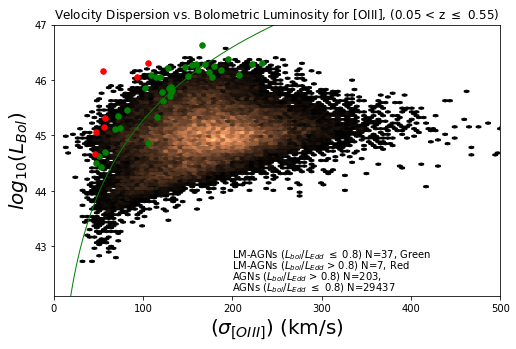

In [28]:
o3_sig_lmagn_great = dflmagn_great['o3_sigma'].values
o3_sig_lmagn_less = dflmagn_less['o3_sigma'].values
o3_sig_agn = dfagn['o3_sigma'].values
o3_lumin_lmagn_great = (np.log10(dflmagn_great['L_bol'].astype(float))).values
o3_lumin_lmagn_less = (np.log10(dflmagn_less['L_bol'].astype(float))).values
o3_lumin_agn = (np.log10(dfagn['L_bol'].astype(float))).values
rand_sig = rand_sig
L_edd_rand = L_edd_rand

plt_density_2(o3_sig_lmagn_great, o3_sig_lmagn_less, o3_sig_agn, o3_lumin_lmagn_great, o3_lumin_lmagn_less, o3_lumin_agn, rand_sig, L_edd_rand, alpha=1)

In [29]:
print(len(dflmagn_less))
print(len(dflmagn_great))

37
7


# Now to overplot these points on BPT

In [30]:
frames_2 = [dflmagn_great, dflmagn_less, dfagn, dfsf]
dfall = pd.concat(frames_2)

frames_3 = [dfagn, dfsf]
dfboth = pd.concat(frames_3)

In [31]:
def agn_classification_line_mod():
    x = np.linspace(-2, 0, 500)
    y = (0.61/(x-0.02-0.1833*(df1.loc[:,"z"].median())))+1.4+0.03*(dfall.loc[:,"z"].median())
    return x, y

def z_zero_kewl_line():
    x = np.linspace(-2, 0, 500)
    y = 0.61/(x-0.02)+1.2
    return x, y

In [32]:
def plot_bpt(nii, halpha, oiii, hbeta, nii2, halpha2, oiii2, hbeta2, nii3, halpha3, oiii3, hbeta3, nii4, halpha4, oiii4, hbeta4, nii5, halpha5, oiii5, hbeta5, fig=None, **kwargs):
    halpha=np.array(halpha,dtype=float)
    halpha2=np.array(halpha2,dtype=float)
    halpha3=np.array(halpha3, dtype=float)
    halpha4=np.array(halpha4, dtype=float)
    halpha5=np.array(halpha5, dtype=float)
    
    nii=np.array(nii,dtype=float)
    nii2=np.array(nii2,dtype=float)
    nii3=np.array(nii3,dtype=float)
    nii4=np.array(nii4, dtype=float)
    nii5=np.array(nii5, dtype=float)

    hbeta=np.array(hbeta,dtype=float)
    hbeta2=np.array(hbeta2,dtype=float)
    hbeta3=np.array(hbeta3,dtype=float)
    hbeta4=np.array(hbeta4, dtype=float)
    hbeta5=np.array(hbeta5, dtype=float)
    
    oiii=np.array(oiii,dtype=float)
    oiii2=np.array(oiii2,dtype=float)
    oiii3=np.array(oiii3,dtype=float)
    oiii4=np.array(oiii4, dtype=float)
    oiii5=np.array(oiii5, dtype=float)
    
    n2ha=np.log10(nii/halpha)
    o3hb=np.log10(oiii/hbeta)
    
    n2ha2=np.log10(nii2/halpha2)
    o3hb2=np.log10(oiii2/hbeta2)
    
    n2ha3=np.log10(nii3/halpha3)
    o3hb3=np.log10(oiii3/hbeta3)
    
    n2ha4=np.log10(nii4/halpha4)
    o3hb4=np.log10(oiii4/hbeta4)
    
    n2ha5=np.log10(nii5/halpha5)
    o3hb5=np.log10(oiii5/hbeta5)
    
    ###
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    
    sf = ax.hexbin(n2ha, o3hb, gridsize = 100, cmap = "copper", bins = "log", mincnt = 1)
    agn_less = ax.hexbin(n2ha5, o3hb5, gridsize=100, cmap='copper', bins='log', mincnt=1)
    agn_great = plt.scatter(n2ha4, o3hb4, c='c', s=20, alpha=1)
    lmagn_great = plt.scatter(n2ha2,o3hb2, c='r', s=30, **kwargs)
    lmagn_less = plt.scatter(n2ha3,o3hb3, c='g', s=30, **kwargs)
    
    agn_class=agn_classification_line_mod()
    z_zero = z_zero_kewl_line()
    #plotting the mixing line
    mix=plt.plot([-0.466, 0.003], [-0.408, 0.979], c='limegreen')
    agn_0=plt.plot(agn_class[0], agn_class[1], c='r')
    agn_1=plt.plot(z_zero[0], z_zero[1], c='b', linestyle='--')
    
    #cb = fig.colorbar(agn, ax=ax)
    #cb.set_label(r'$log_{10}(N)$')
    #plt.text(-1.9, 1.55, 'Starforming N=30981', fontsize=10)
    #plt.text(-1.9, 1.4, 'AGNs N=25666', fontsize=10)
    #plt.text(-1.9, 1.55, 'LMAGNs ($L_{bol}$/$L_{Edd}$) $\geq$ 1.0 (Red) N=13', fontsize=10)
    #plt.text(-1.9, 1.4, 'LMAGNs ($L_{bol}$/$L_{Edd}$) < 1.0 (Green) N=8', fontsize=10)
    #plt.text(-1.95, -0.5, 'AGNs ($L_{bol}$/$L_{Edd}$) $\geq$ 0.9 (Blue) N=847', fontsize=10)
    #plt.text(-1.95, -0.35, 'AGNs ($L_{bol}$/$L_{Edd}$) < 0.9 N=24430', fontsize=10)
    #plt.text(-1.95, -0.2, 'SF N=14733', fontsize=10)
    
    plt.xlim(-2.0,0.75)
    plt.ylim(-1.25,1.75)
    plt.title('Lookback Time: 5.386 Gyr, (0.005 < z$\leq$0.55)')
    plt.xlabel(r'$log_{10}($[NII]/h$\alpha)$')
    plt.ylabel(r'$log_{10}($[OIII]/h$\beta)$')
    #plt.savefig('std_bpt_highlight_agns_edd_ratio.png')    
    plt.show()
    return

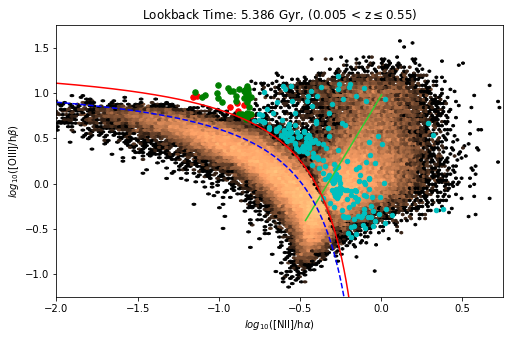

In [33]:
halpha = dfsf['ha'].values
halpha2 = dflmagn_great['ha'].values
halpha3 = dflmagn_less['ha'].values
halpha4 = dfagn_great['ha'].values
halpha5 = dfagn_less['ha'].values

hbeta = dfsf['hb'].values
hbeta2 = dflmagn_great['hb'].values
hbeta3 = dflmagn_less['hb'].values
hbeta4 = dfagn_great['hb'].values
hbeta5 = dfagn_less['hb'].values

nii = dfsf['n2'].values
nii2 = dflmagn_great['n2'].values
nii3 = dflmagn_less['n2'].values
nii4 = dfagn_great['n2'].values
nii5 = dfagn_less['n2'].values

oiii = dfsf['o3'].values
oiii2 = dflmagn_great['o3'].values
oiii3 = dflmagn_less['o3'].values
oiii4 = dfagn_great['o3'].values
oiii5 = dfagn_less['o3'].values

plot_bpt(nii, halpha, oiii, hbeta, nii2, halpha2, oiii2, hbeta2, nii3, halpha3, oiii3, hbeta3, nii4, halpha4, oiii4, hbeta4, nii5, halpha5, oiii5, hbeta5, alpha = 1)